# 논문 : 합성데이터를 활용한 유방암 수술 후 치료 유형별 생존 분석: 조직학적 아형을 고려한 인과기반 Uplift 모델링 접근

# 1. 데이터 읽기

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

import missingno as msno

from sklearn.model_selection import train_test_split

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini
from causalml.metrics import auuc_score, qini_score

from IPython.display import Image

In [17]:
# 성능이 주 목적인 머신러닝 구축환경이 아니기에 train과 test를 하나의 데이터로 합침

synbreast_trainset = pd.read_excel('Adjusted_synbreast_trainset.xlsx')
synbreast_testset = pd.read_excel('Adjusted_synbreast_test.xlsx')

df = pd.concat([synbreast_trainset,synbreast_testset], axis=0)
df

,No,AGE,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,T1,T1mi,T1a,...,PR,AR,BCS,Mestectomy,pan hysterosalpingo oophorectomy,Chemotherapy,Hormone therapy,Radiation Therapy,Death,Survival period
0,0,33,0,1,0,0,1,1,0,0,...,2,9,1,99,0,1,0,1,0,472
1,1,72,0,1,1,1,0,0,0,1,...,1,99,1,0,0,0,1,1,0,835
2,2,41,0,0,0,0,0,0,0,1,...,99,9,99,1,0,1,1,0,1,1136
3,3,61,1,0,0,1,0,1,0,0,...,1,99,99,0,0,0,1,1,1,145
4,4,44,0,1,0,0,0,0,1,0,...,2,99,0,99,0,0,1,1,1,906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,56,0,1,0,1,1,0,1,0,...,1,99,1,0,0,1,1,1,0,145
4996,4996,65,0,0,1,0,1,0,1,0,...,1,2,1,0,0,1,1,1,1,1360
4997,4997,44,0,1,0,0,1,1,0,0,...,1,9,1,0,1,1,0,1,0,67
4998,4998,58,0,1,0,1,1,0,0,0,...,2,9,1,99,1,0,1,0,0,133


# 2. 변수 선정
- 주제와 연관된 변수만 추출
- 처치 : 치료여부 3개 변수
- 결과 : 사망여부 변수
- 공변량 : 조직학적진단명 5개 변수
    - inductal carcinoma : 관상피내암종
    - infiltrating duct carcinoma : 침윤성 관암종
    - adenocarcinoma : 선암종
    - lobular carcinoma : 소엽암종
    - Metaplastic carcinoma : 화생성암종
- (조건이 되는 수술 후이니깐 BCS, Mestectomy 2개 변수)

In [18]:
a = {
  'AGE': '진단시연령',  # 진단 당시 연령 (예: 45세)
  'inductal carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '관상피암'으로, 유방의 관에서 시작되는 암)
  'infiltrating duct carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '침윤성 관암'으로, 유방의 관에서 시작되어 주변 조직으로 침윤하는 암)
  'adenocarcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '선암'으로, 유방의 샘 조직에서 발생하는 암)
  'lobular carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '소엽암'으로, 유방의 소엽에서 시작되는 암)
  'Metaplastic carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '화생암'으로, 유방암 세포가 다른 조직 형태로 변형된 암)
  'TX': '병기STAGE', # 존재 안함
  'T0': '병기STAGE', # 존재 안함
  'T1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 종양 크기 및 침습 정도에 따라 T1 단계로 분류)
  'T1mi': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 미세 침습성 암으로 T1의 하위 분류)
  'T1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T1 중 0.1~0.5cm 크기의 종양)
  'T1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T1 중 0.5~1cm 크기의 종양)
  'T1c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 이미지에서 T1c는 0=아니오, 1=예로 나타남, T1 중 1~2cm 크기의 종양)
  'T2': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 2~5cm 크기의 종양)
  'T2a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T2 중 2~3cm 크기의 종양)
  'T2b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T2 중 3~5cm 크기의 종양)
  'T3': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 5cm 이상의 종양 또는 인접 구조 침범)
  'T4': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 종양이 피부나 흉벽으로 침범된 경우)
  'Nx': '병기STAGE', # 존재 안함
  'N1mi': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 림프절 미세 전이)
  'N1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 1~3개 림프절 전이)
  'N1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 이동성 림프절 전이)
  'N1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 내부 유방 림프절 전이)
  'N1c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 피부나 근육 내 전이)
  'N2': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 4~9개 림프절 전이)
  'N2a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N2 중 이동성 림프절 4~9개 전이)
  'N2b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N2 중 흉곽 내 또는 상완 림프절 전이)
  'N3': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 10개 이상 림프절 전이)
  'N3a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 10개 이상 흉곽 아래 림프절 전이)
  'N3b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 흉곽 내 또는 유방 위 림프절 전이)
  'N3c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 쇄골 위 림프절 전이)
  'M1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 원격 전이 존재)
  'M1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, M1 중 단일 원격 전이)
  'M1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, M1 중 다발성 원격 전이)
  'Type of Drink': '음주종류',  # 음주 종류 (예: 0=맥주,1=소주, 2=양주, 99=기타)
  'Smoke': '흡연여부',  # 흡연 여부 (예: 0=비흡연, 1=흡연, 2=과거 흡연)
  'Age of Menarch': '초경연령',  # 초경 연령 (예: 16, 99=모름)
  'Age of Menopause': '폐경연령',  # 폐경 연령 (예: 55, 99=모름)
  'Marriage': '결혼여부',  # 결혼 여부 (예: 0=아니오, 1=예, 99=모름)
  'Age at first birth': '첫출산연령',  # 첫 출산 연령 (예: 20, 99=해당사항 없음)
  'Number of births': '출산자녀수',  # 출산 자녀 수 (예: 3, 99=해당사항 없음)
  'COCP': '경구피임약사용여부',  # 경구 피임약 사용 여부 (예: 0=아니오, 1=예, 99=모름)
  'HRT': 'HRT 사용여부',  # 호르몬 대체 요법(HRT) 사용 여부 (예: 0=아니오, 1=예, 99=모름)
  'Height': '신장값',  # 신장 값 (예: 158cm)
  'Weight': '체중측정값',  # 체중 값 (예: 58kg)
  'BRCA1 PVs': 'BRCA1 병원변형체 검출 여부',  # BRCA1 병원변형체 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA1 VUS': 'BRCA1 미확인변이 검출 여부',  # BRCA1 미확인변이 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA2 PVs': 'BRCA2 병원변형체 검출 여부',  # BRCA2 병원변형체 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA2 VUS': 'BRCA2 미확인변이 검출 여부',  # BRCA2 미확인변이 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'ER': '면역병리ER검사결과코드',  # Estrogen Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'PR': '면역병리PR검사결과코드',  # Progesterone Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'AR': '면역병리AR검사결과코드',  # Androgen Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BCS': '유방보전적절제술여부 BCS',  # 유방보전적절제술 여부 (예: 0=아니오, 1=예, 99=해당사항 없음)
  'Mestectomy': '유방전절제술여부',  # 유방 전절제술 여부 (예: 0=아니오, 1=예, 99=해당사항 없음)
  'pan hysterosalpingo oophorectomy': '양측난관난소절제술여부',  # 양측 난관 난소 절제술 여부 (예: 0=아니오, 1=예)
  'Chemotherapy': '항암치료여부',  # 항암치료 여부 (예: 0=아니오, 1=예)
  'Hormone therapy': '호르몬치료여부',  # 호르몬치료 여부 (예: 0=아니오, 1=예)
  'Radiation Therapy': '방사선치료여부',  # 방사선치료 여부 (예: 0=아니오, 1=예)
  'Death': '사망여부',  # 사망 여부 (예: 0=아니오, 1=예)
  'Survival period': '암진단후생존일수',  # 암 진단 후 생존 일수 (예: 267일)
}
len(a)

60

In [19]:
df = df[['AGE','inductal carcinoma', 'infiltrating duct carcinoma','adenocarcinoma', 'lobular carcinoma', 'Metaplastic carcinoma','BCS','Mestectomy', 'Chemotherapy', 'Hormone therapy', 'Radiation Therapy', 'Death']]
df[['BCS','Mestectomy']] = df[['BCS','Mestectomy']].replace([99,0], np.nan)
df = df.dropna(axis=0, how='all', subset=['BCS','Mestectomy'])
df = df.drop(columns=['BCS','Mestectomy'])
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,AGE,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,Chemotherapy,Hormone therapy,Radiation Therapy,Death
0,33,0,1,0,0,1,1,0,1,0
1,72,0,1,1,1,0,0,1,1,0
2,41,0,0,0,0,0,1,1,0,1
5,48,1,1,0,0,0,0,1,1,0
6,71,0,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
4995,56,0,1,0,1,1,1,1,1,0
4996,65,0,0,1,0,1,1,1,1,1
4997,44,0,1,0,0,1,1,0,1,0
4998,58,0,1,0,1,1,0,1,0,0


<Axes: >

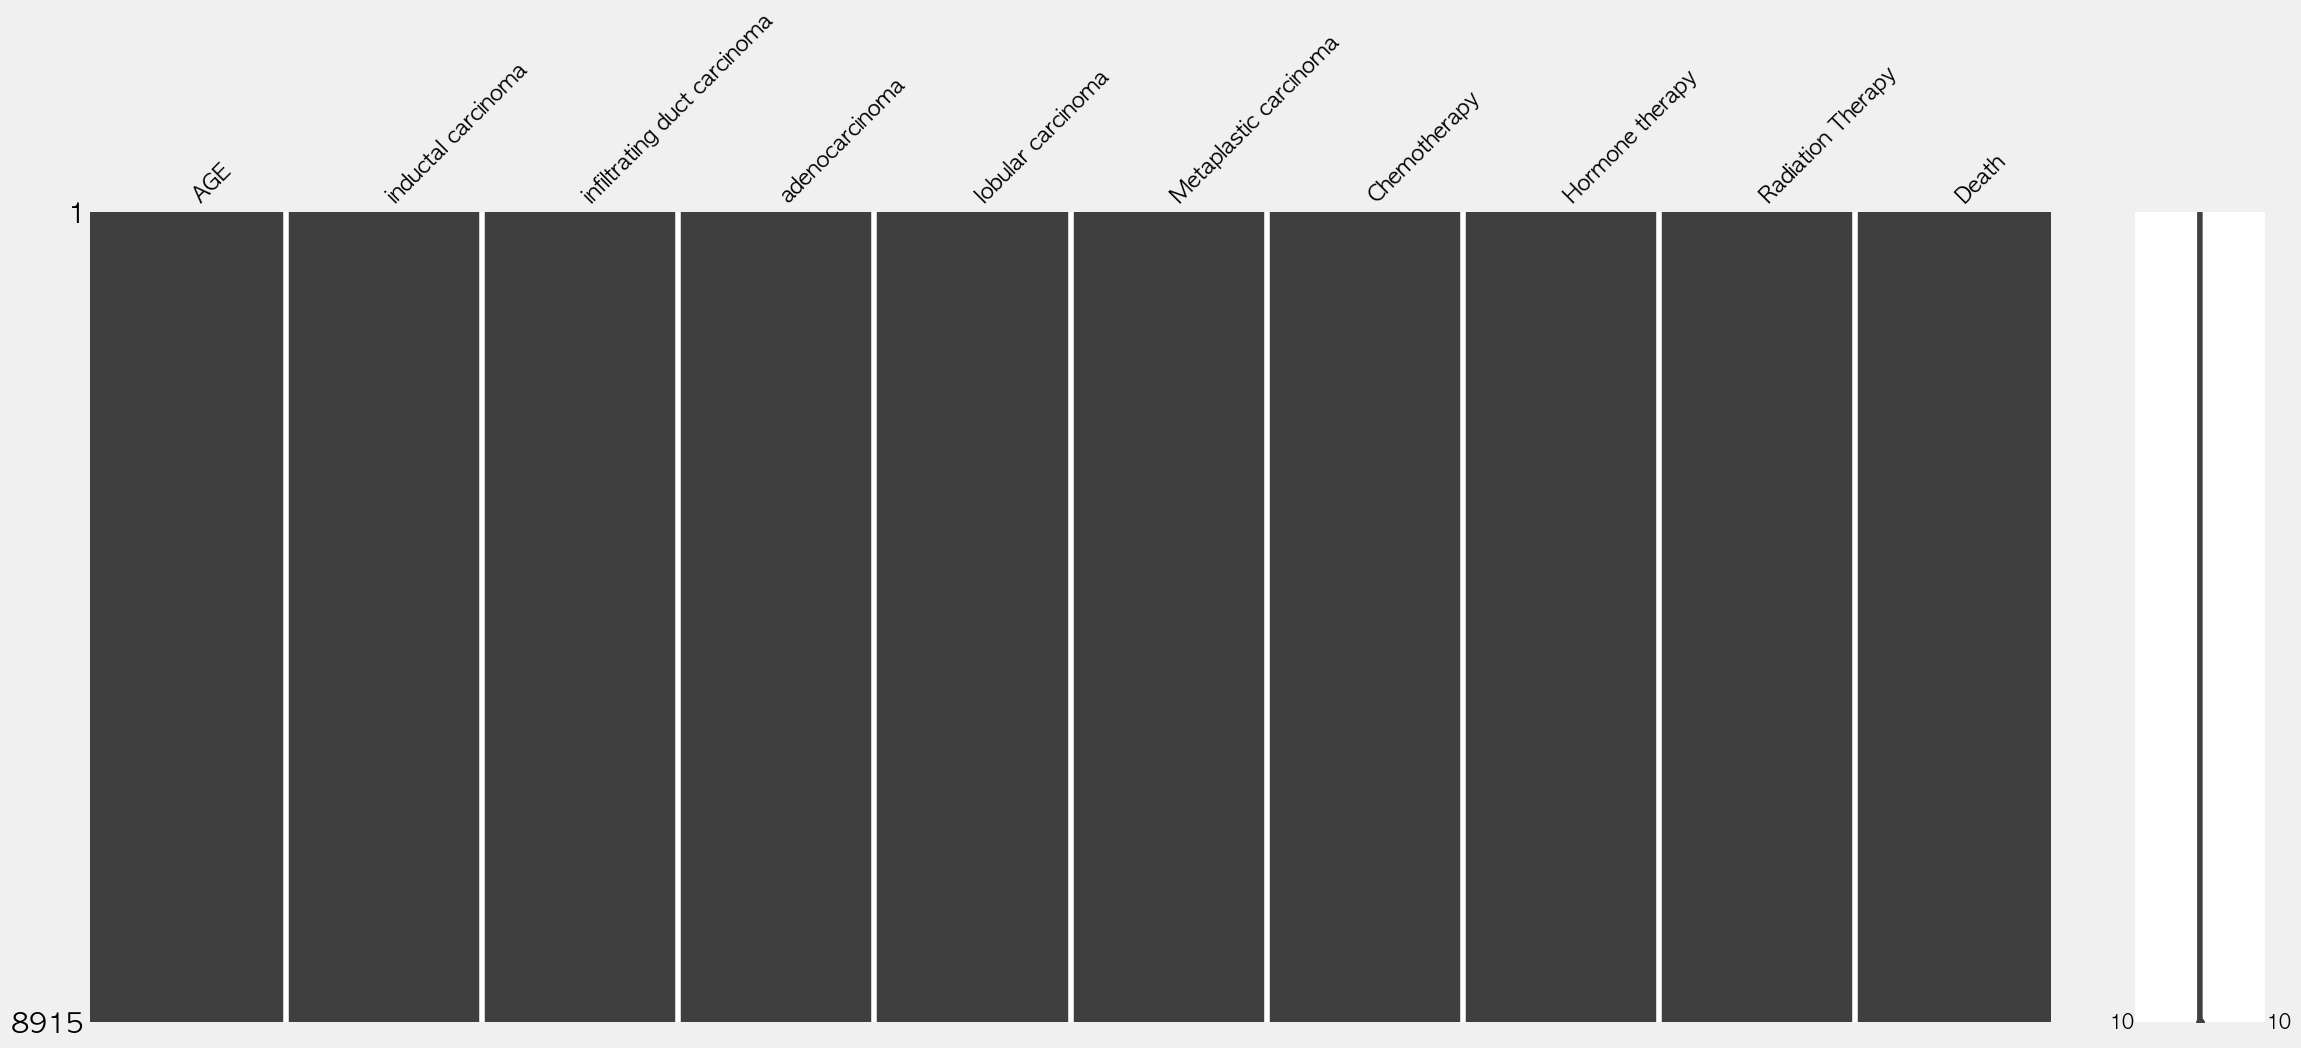

In [20]:
msno.matrix(df)

# 3. 데이터 분석

In [21]:
synbreast = df.copy()

treatment_mapping = {
    (0,0,0): 'c',   # 무처치
    (1,0,0): 't1',   # 항암 단독
    (0,1,0): 't2',   # 호르몬 단독
    (0,0,1): 't3',   # 방사선 단독  
    (1,1,0): 't4',   # 항암+호르몬
    (1,0,1): 't5',   # 항암+방사선
    (0,1,1): 't6',   # 호르몬+방사선
    (1,1,1): 't7'    # 삼중요법
}

synbreast['combo_tx'] = synbreast[['Chemotherapy','Hormone therapy','Radiation Therapy']]\
                  .apply(tuple, axis=1).map(treatment_mapping)
synbreast = synbreast.drop(columns=['Chemotherapy','Hormone therapy', 'Radiation Therapy'])
synbreast

,AGE,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,Death,combo_tx
0,33,0,1,0,0,1,0,t5
1,72,0,1,1,1,0,0,t6
2,41,0,0,0,0,0,1,t4
5,48,1,1,0,0,0,0,t6
6,71,0,1,0,0,0,1,t5
...,...,...,...,...,...,...,...,...
4995,56,0,1,0,1,1,0,t7
4996,65,0,0,1,0,1,1,t7
4997,44,0,1,0,0,1,0,t5
4998,58,0,1,0,1,1,0,t2


In [96]:
#synbreast[['Death']] = synbreast[['Death']].replace([0, 1], [1, 0])

In [22]:
synbreast.combo_tx.value_counts()

combo_tx
t7    2089
t4    1344
t5    1302
t6    1199
t1     853
t3     796
t2     765
c      567
Name: count, dtype: int64

In [23]:
synbreast['combo_tx'] = synbreast['combo_tx'].replace(['t7', 't5', 't4', 't6', 't3', 't2', 't1','c'], [7,6,5,4,3,2,1,0])

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [24]:
synbreast

,AGE,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,Death,combo_tx
0,33,0,1,0,0,1,0,6
1,72,0,1,1,1,0,0,4
2,41,0,0,0,0,0,1,5
5,48,1,1,0,0,0,0,4
6,71,0,1,0,0,0,1,6
...,...,...,...,...,...,...,...,...
4995,56,0,1,0,1,1,0,7
4996,65,0,0,1,0,1,1,7
4997,44,0,1,0,0,1,0,6
4998,58,0,1,0,1,1,0,2


In [25]:
for i in ['inductal carcinoma', 'infiltrating duct carcinoma', 'adenocarcinoma',
       'lobular carcinoma', 'Metaplastic carcinoma']:
    synbreast[i] = synbreast[i].astype('category')

In [26]:
df_train, df_test = train_test_split(synbreast, test_size=0.2, random_state=111)
x_names = ['AGE','inductal carcinoma', 'infiltrating duct carcinoma', 'adenocarcinoma','lobular carcinoma', 'Metaplastic carcinoma']

In [27]:
df_train['combo_tx'].unique()

array([7, 6, 5, 4, 3, 2, 0, 1])

In [35]:
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier # 메타 학습자 임포트


# --- S-learner for each treatment vs Control (0) ---
print("\n--- S-Learner: Estimating CATE for each Treatment vs Control (0) ---")

# 기준 그룹 설정
control_group = 0
treatment_categories_numeric = [0,1,2,3,4,5,6,7]
treatment_groups = [g for g in treatment_categories_numeric if g != control_group]

s_learner_cates = {} # 각 처치에 대한 CATE 결과를 저장할 딕셔너리

for trt_group in treatment_groups:
    print(f"\n--- Estimating CATE for Treatment '{trt_group}' vs Control '{control_group}' ---")

    # 해당 두 그룹만 필터링
    df_train_subset = df_train[df_train['combo_tx'].isin([control_group, trt_group])].copy()
    df_test_subset = df_test[df_test['combo_tx'].isin([control_group, trt_group])].copy()

    # 이진 처치 변수 생성: trt_group이면 1 (처리), control_group이면 0 (통제)
    df_train_subset['is_treated'] = (df_train_subset['combo_tx'] == trt_group).astype(int)
    df_test_subset['is_treated'] = (df_test_subset['combo_tx'] == trt_group).astype(int)

    # 특징(X), 처치(a), 결과(y) 정의
    X_train = df_train_subset[x_names]
    a_train = df_train_subset['is_treated']
    y_train = df_train_subset['Death']

    X_test = df_test_subset[x_names]
    a_test = df_test_subset['is_treated'] # S-learner.predict는 a를 사용하지 않음
    y_test = df_test_subset['Death']

    # S-learner 인스턴스 생성 및 학습
    s_learner = BaseSClassifier(learner=RandomForestClassifier(random_state=42))
    s_learner.fit(X=X_train, treatment=a_train, y=y_train)

    # 테스트 데이터에 대한 CATE 추정
    cate_s = s_learner.predict(X_test) # predict에는 a_test가 필요 없음
    s_learner_cates[f'T{trt_group}_vs_T{control_group}'] = cate_s
    print(f"S-Learner CATE ('{trt_group}' vs '{control_group}') for first 10 test samples:\n{cate_s[:10]}\n")


--- S-Learner: Estimating CATE for each Treatment vs Control (0) ---

--- Estimating CATE for Treatment '1' vs Control '0' ---
S-Learner CATE ('1' vs '0') for first 10 test samples:
[[-0.043     ]
 [ 0.51309524]
 [-0.25366667]
 [-0.13512193]
 [-0.04600216]
 [ 0.44      ]
 [-0.40166667]
 [-0.26      ]
 [-0.01666667]
 [ 0.40266667]]


--- Estimating CATE for Treatment '2' vs Control '0' ---
S-Learner CATE ('2' vs '0') for first 10 test samples:
[[-0.00083333]
 [-0.43484127]
 [ 0.395     ]
 [ 0.556     ]
 [ 0.54333333]
 [-0.81      ]
 [-0.15      ]
 [ 0.02      ]
 [ 0.69266667]
 [-0.0775    ]]


--- Estimating CATE for Treatment '3' vs Control '0' ---
S-Learner CATE ('3' vs '0') for first 10 test samples:
[[ 0.07      ]
 [ 0.61933333]
 [-0.64      ]
 [ 0.04394048]
 [-0.02507143]
 [ 0.50666667]
 [-0.3       ]
 [-0.07283333]
 [-0.06797619]
 [-0.72866667]]


--- Estimating CATE for Treatment '4' vs Control '0' ---
S-Learner CATE ('4' vs '0') for first 10 test samples:
[[-0.83533333]
 [ 0.03

In [32]:
# --- T-learner: Estimating CATE for multiple treatments ---
print("\n--- T-Learner: Estimating CATE for multiple treatments ---")

# X_train과 y_train 정의
X_train_full = df_train[x_names]
y_train_full = df_train['Death']
t_train_full = df_train['combo_tx'] # 범주형 처치 변수 (0~7)

X_test_full = df_test[x_names]

# 각 처치 그룹에 대한 모델을 저장할 딕셔너리
group_models = {}
# 각 처치 그룹별로 예측 모델 학습 (이진 목적 변수이므로 분류 모델)
for trt_group in treatment_categories_numeric:
    print(f"Training model for Treatment Group '{trt_group}'...")
    X_group = X_train_full[t_train_full == trt_group]
    y_group = y_train_full[t_train_full == trt_group]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_group, y_group)
    group_models[trt_group] = model

# 테스트 데이터에 대해 각 모델로 예측 (결과가 이진이므로 predict_proba 사용)
# 예측값은 클래스 1 (긍정)에 대한 확률입니다.
predicted_probabilities = {}
for trt_group, model in group_models.items():
    predicted_probabilities[trt_group] = model.predict_proba(X_test_full)[:, 1]

# CATE 계산: 기준 그룹 '0' 대비 각 처치의 효과
t_learner_cates = {}
control_prob = predicted_probabilities[control_group] # 기준 그룹 0의 예측 확률

for trt_group in treatment_groups:
    cate_value = predicted_probabilities[trt_group] - control_prob
    t_learner_cates[f'T{trt_group}_vs_T{control_group}'] = cate_value
    print(f"T-Learner CATE ('{trt_group}' vs '{control_group}') for first 10 test samples:\n{cate_value[:10]}\n")


--- T-Learner: Estimating CATE for multiple treatments ---
Training model for Treatment Group '0'...
Training model for Treatment Group '1'...
Training model for Treatment Group '2'...
Training model for Treatment Group '3'...
Training model for Treatment Group '4'...
Training model for Treatment Group '5'...
Training model for Treatment Group '6'...
Training model for Treatment Group '7'...
T-Learner CATE ('1' vs '0') for first 10 test samples:
[ 0.27583333  0.14761905 -0.01666667  0.57533333 -0.03       -0.17233333
 -0.25       -0.21833333 -0.315       0.5275    ]

T-Learner CATE ('2' vs '0') for first 10 test samples:
[-0.08666667 -0.23166667  0.005       0.18872619  0.06333333  0.25316667
 -0.44916667  0.22716667 -0.343      -0.00416667]

T-Learner CATE ('3' vs '0') for first 10 test samples:
[ 0.1675      0.55416667 -0.724       0.72166667  0.45566667 -0.4655
 -0.59566667 -0.29216667 -0.16966667  0.68916667]

T-Learner CATE ('4' vs '0') for first 10 test samples:
[ 0.55666667  0.

In [38]:
# --- 메타 학습자들에 대한 공통 설정 ---
base_classifier_learner = RandomForestClassifier(random_state=42)
base_regressor_learner = RandomForestRegressor(random_state=42)

control_group = 0 # 기준 그룹 설정
treatment_groups = [g for g in treatment_categories_numeric if g != control_group]


# --- X-learner (BaseXClassifier) for each treatment vs Control (0) ---
print("\n--- X-Learner: Estimating CATE for each Treatment vs Control (0) ---")

x_learner_cates = {}

for trt_group in treatment_groups:
    print(f"\n--- Estimating CATE for Treatment '{trt_group}' vs Control '{control_group}' ---")

    # S-learner와 동일하게 해당 두 그룹만 필터링
    # 처치 변수 이름을 'combo_tx'로 수정
    df_train_subset = df_train[df_train['combo_tx'].isin([control_group, trt_group])].copy()
    df_test_subset = df_test[df_test['combo_tx'].isin([control_group, trt_group])].copy()

    # 이진 처치 변수 생성
    # 처치 변수 이름을 'combo_tx'로 수정
    df_train_subset['is_treated'] = (df_train_subset['combo_tx'] == trt_group).astype(int)
    # df_test_subset은 X-learner.predict에 사용될 X만 필요하므로 is_treated가 직접 사용되지 않음

    # 특징(X), 처치(a), 결과(y) 정의
    X_train = df_train_subset[x_names]
    a_train = df_train_subset['is_treated']
    y_train = df_train_subset['Death'] # 목적 변수 이름을 'Death'로 수정

    X_test = df_test_subset[x_names]

    # X-learner 인스턴스 생성 및 학습 (올바른 매개변수 이름 사용)
    x_learner = BaseXClassifier(
        # control_outcome_learner와 treatment_outcome_learner는 X-learner의 1단계에서 Y(0)과 Y(1)을 예측
        control_outcome_learner=base_classifier_learner,
        treatment_outcome_learner=base_classifier_learner,
        # control_effect_learner와 treatment_effect_learner는 1단계 예측 잔차를 학습 (X-learner의 2단계)
        control_effect_learner=base_regressor_learner,
        treatment_effect_learner=base_regressor_learner,
        # effect_learner는 최종적으로 CATE를 예측하는 모델
        effect_learner=base_regressor_learner
    )
    # fit 메서드에서 treatment=a_train 대신 a=a_train 사용
    x_learner.fit(X=X_train, treatment=a_train, y=y_train)

    # 테스트 데이터에 대한 CATE 추정
    cate_x = x_learner.predict(X_test)
    x_learner_cates[f'T{trt_group}_vs_T{control_group}'] = cate_x
    print(f"X-Learner CATE ('{trt_group}' vs '{control_group}') for first 10 test samples:\n{cate_x[:10].round(4)}\n")



--- X-Learner: Estimating CATE for each Treatment vs Control (0) ---

--- Estimating CATE for Treatment '1' vs Control '0' ---


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

X-Learner CATE ('1' vs '0') for first 10 test samples:
[[-0.0811]
 [ 0.3806]
 [-0.0992]
 [ 0.0646]
 [ 0.1468]
 [ 0.4319]
 [-0.1541]
 [-0.2405]
 [-0.2826]
 [ 0.0636]]


--- Estimating CATE for Treatment '2' vs Control '0' ---


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

X-Learner CATE ('2' vs '0') for first 10 test samples:
[[-0.1454]
 [-0.1573]
 [ 0.4676]
 [ 0.4786]
 [ 0.3944]
 [-0.5121]
 [-0.1602]
 [ 0.0783]
 [ 0.6422]
 [-0.1838]]


--- Estimating CATE for Treatment '3' vs Control '0' ---


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

X-Learner CATE ('3' vs '0') for first 10 test samples:
[[ 0.1048]
 [ 0.3955]
 [-0.4933]
 [-0.0249]
 [ 0.1259]
 [ 0.5341]
 [-0.5243]
 [-0.1764]
 [ 0.1579]
 [-0.2886]]


--- Estimating CATE for Treatment '4' vs Control '0' ---


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

X-Learner CATE ('4' vs '0') for first 10 test samples:
[[-0.7142]
 [ 0.3587]
 [ 0.0399]
 [-0.6003]
 [-0.0175]
 [-0.2013]
 [ 0.4323]
 [-0.0334]
 [-0.4547]
 [ 0.1646]]


--- Estimating CATE for Treatment '5' vs Control '0' ---


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

X-Learner CATE ('5' vs '0') for first 10 test samples:
[[-0.7858]
 [-0.152 ]
 [-0.3418]
 [ 0.1121]
 [ 0.162 ]
 [ 0.1453]
 [-0.0189]
 [-0.15  ]
 [-0.0301]
 [-0.0333]]


--- Estimating CATE for Treatment '6' vs Control '0' ---


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

X-Learner CATE ('6' vs '0') for first 10 test samples:
[[-0.3924]
 [ 0.047 ]
 [-0.0953]
 [ 0.0184]
 [ 0.1801]
 [-0.4472]
 [ 0.2907]
 [-0.6155]
 [-0.0257]
 [ 0.1689]]


--- Estimating CATE for Treatment '7' vs Control '0' ---


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

X-Learner CATE ('7' vs '0') for first 10 test samples:
[[-0.6652]
 [ 0.0187]
 [-0.6461]
 [-0.2267]
 [ 0.2101]
 [ 0.176 ]
 [-0.4012]
 [ 0.2477]
 [-0.3658]
 [-0.0049]]



In [48]:
len(cate_x)

552

In [49]:
# 전체 테스트셋 크기
n_test = df_test.shape[0]

# 전체 테스트셋에 대한 uplift 값 저장 (초기값: 0)
uplift_all = np.zeros(n_test)

# 실제 처치값과 결과값
y_test_all = df_test['Death'].values
a_test_all = df_test['combo_tx'].values

# 각각의 treatment vs control에 대해 uplift를 예측
for trt_group in treatment_groups:
    df_test_subset = df_test[df_test['combo_tx'].isin([control_group, trt_group])].copy()
    X_test = df_test_subset[x_names]

    # 동일한 방식으로 이진 처리 정의
    a_test_binary = (df_test_subset['combo_tx'] == trt_group).astype(int).values

    # 해당 treatment vs control에 대해 CATE 예측
    cate_x = x_learner_cates[f'T{trt_group}_vs_T{control_group}']  # 이전 루프에서 저장된 값

    # 해당 subset의 인덱스를 찾아 전체 결과에 삽입
    subset_index = df_test_subset.index
    uplift_all[subset_index] = cate_x


ValueError: shape mismatch: value array of shape (289,1) could not be broadcast to indexing result of shape (289,)

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


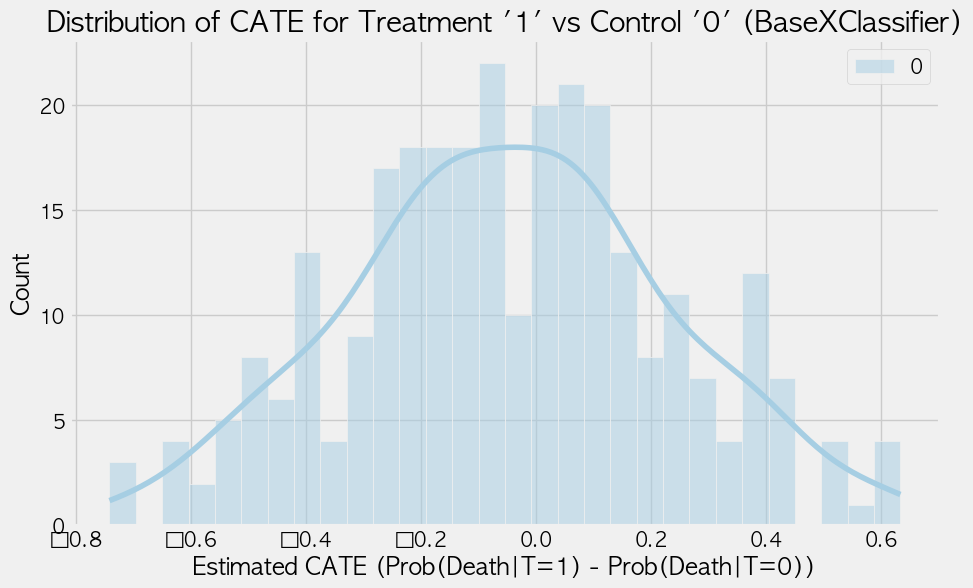

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


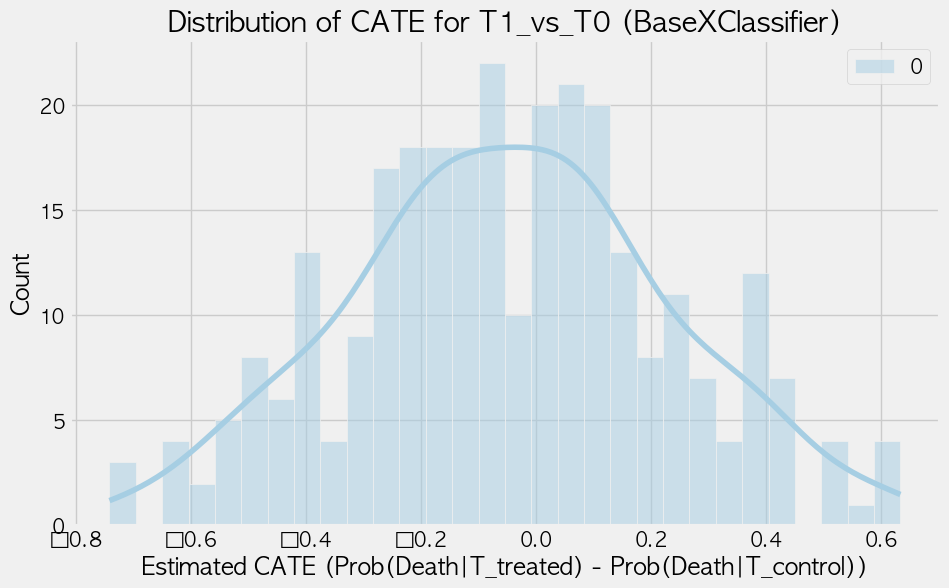

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


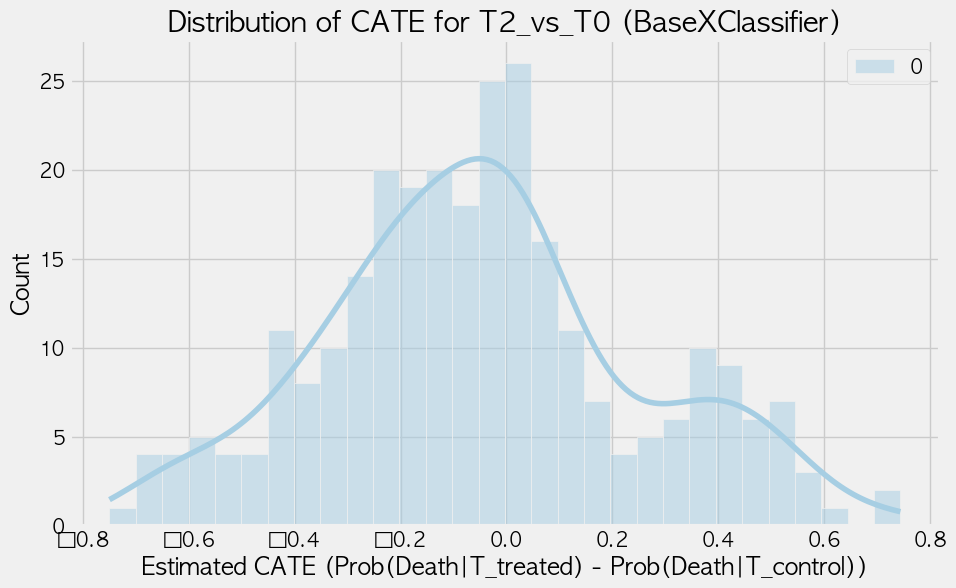

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


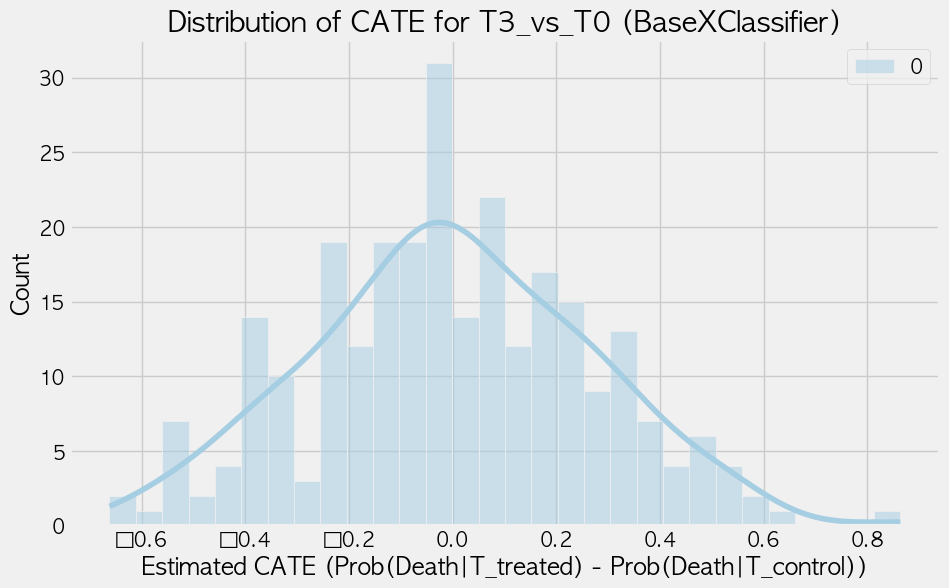

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


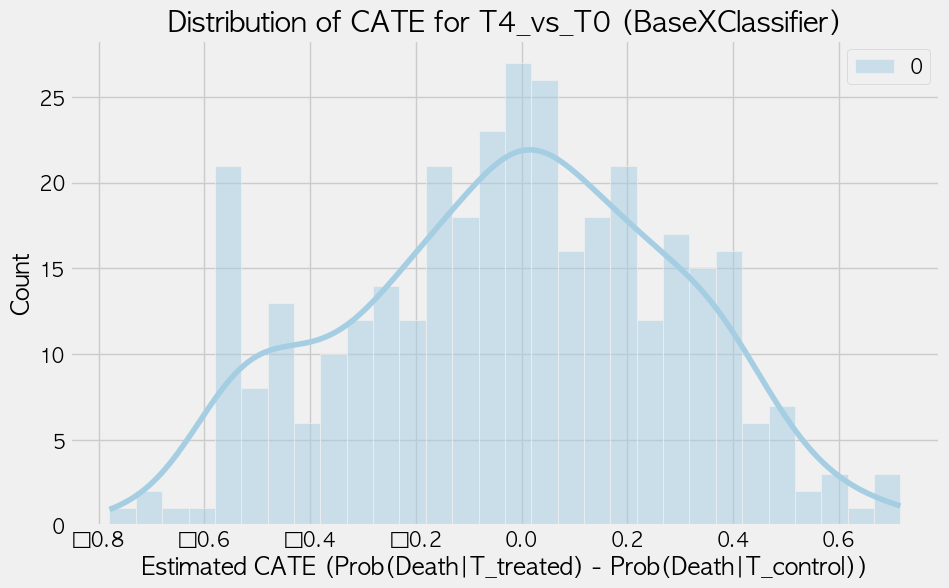

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


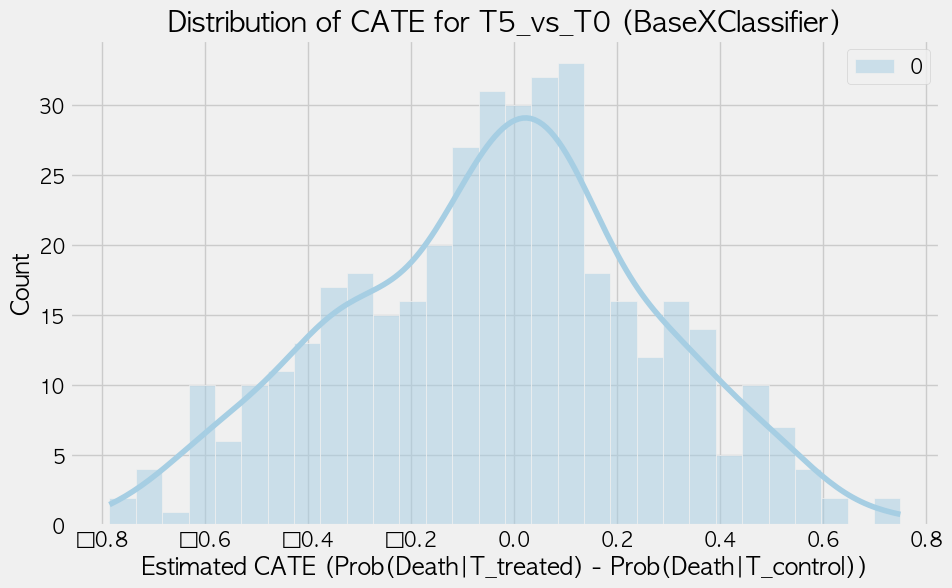

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


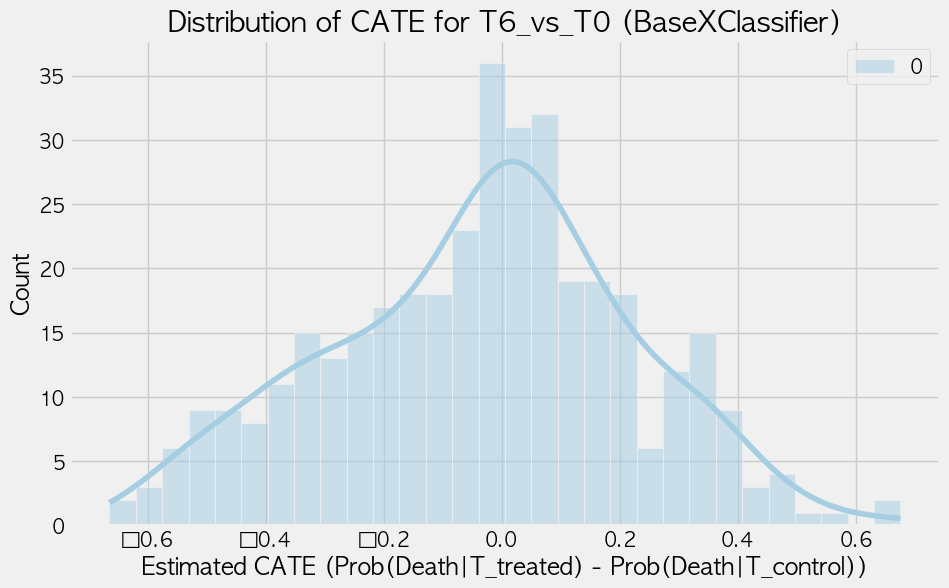

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


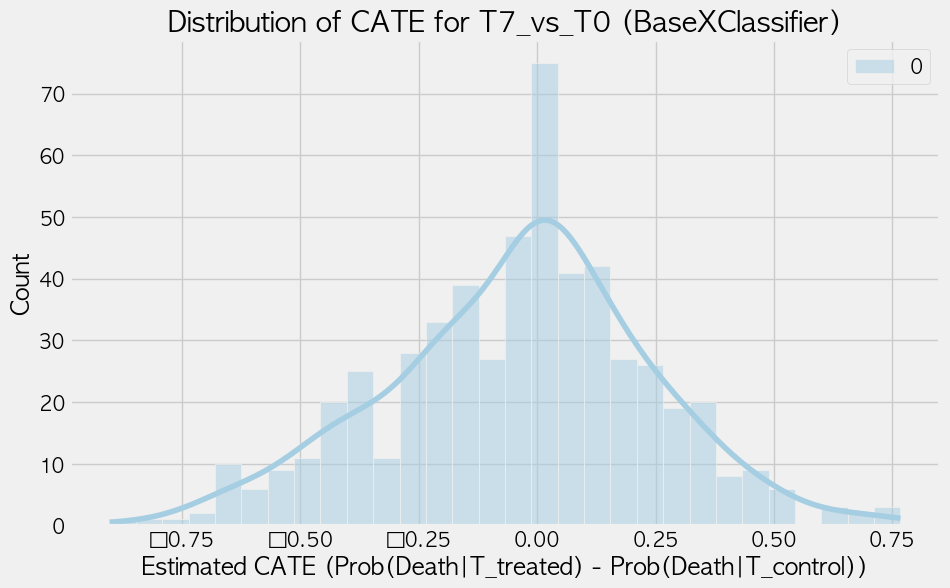

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예시: 'T1_vs_T0'에 대한 CATE 분포 시각화
if 'T1_vs_T0' in x_learner_cates:
    plt.figure(figsize=(10, 6))
    sns.histplot(x_learner_cates['T1_vs_T0'], kde=True, bins=30)
    plt.title(f"Distribution of CATE for Treatment '1' vs Control '0' (BaseXClassifier)")
    plt.xlabel("Estimated CATE (Prob(Death|T=1) - Prob(Death|T=0))")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# 모든 처치 그룹에 대해 반복
for key, cate_values in x_learner_cates.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(cate_values, kde=True, bins=30)
    plt.title(f"Distribution of CATE for {key} (BaseXClassifier)")
    plt.xlabel("Estimated CATE (Prob(Death|T_treated) - Prob(Death|T_control))")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

In [69]:
df_train['Survival period'].max()

1825

Text(0.5, 1.0, 'ㅇㅇ')

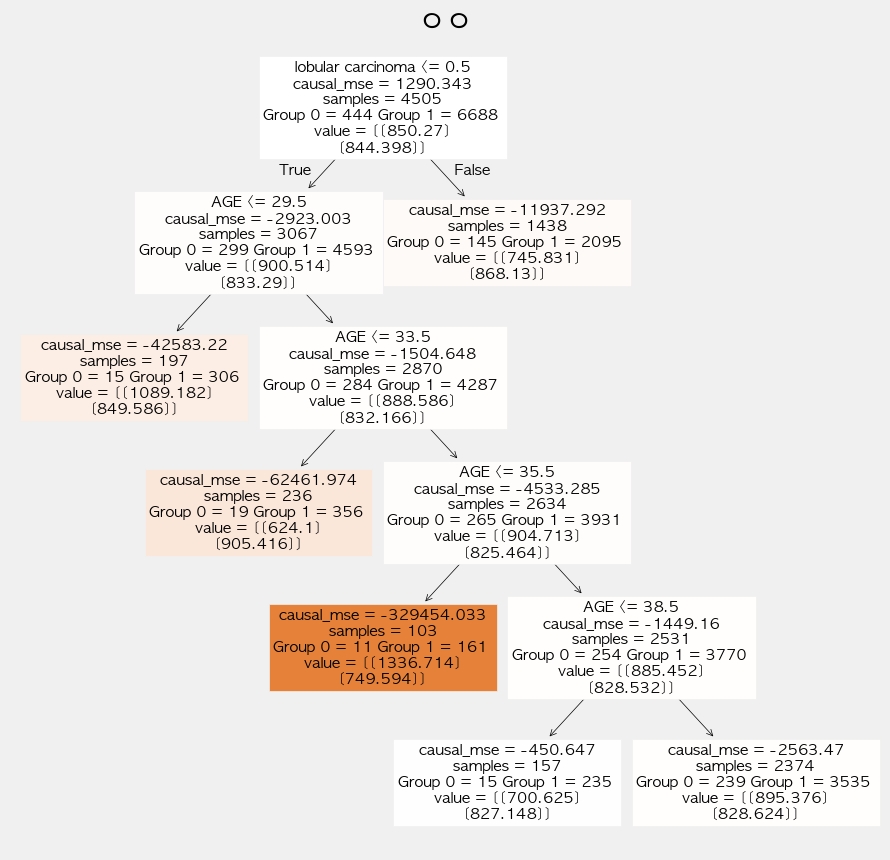

In [70]:
from causalml.inference.tree.plot import plot_causal_tree 
import numpy as np # 예시 데이터 생성을 위해 추가

plt.figure(figsize=(10,10))
graph = plot_causal_tree(uplift_model.estimators_[1],
                         feature_names=df_train[x_names].columns,
                         filled=True)
plt.title('ㅇㅇ')
# 그래프 출력 (예: Image 객체로 Jupyter에서 시각화)
# from IPython.display import Image
# Image(graph.create_png())

In [ ]:
# 업리프트 트리 시각화
graph = uplift_tree_plot(uplift_model.uplift_forest[4].fitted_uplift_tree, df_train[x_names].columns)
Image(graph.create_png())

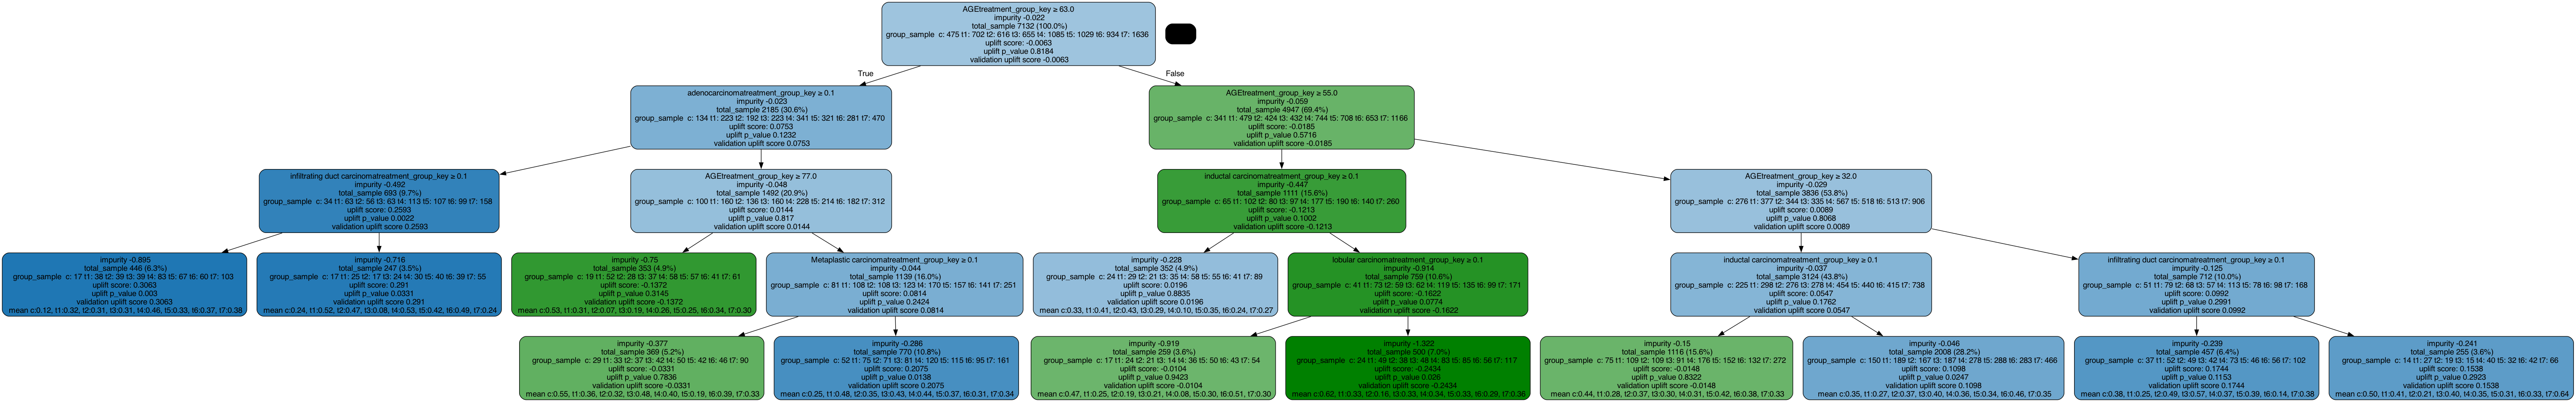

In [127]:
graph = uplift_tree_plot(uplift_model.uplift_forest[4].fitted_uplift_tree, df_train[x_names].columns)
Image(graph.create_png())

In [95]:
import graphviz
graph = uplift_tree_plot(uplift_model.uplift_forest[1].fitted_uplift_tree, df_train[x_names].columns)
output_filename = 'uplift_tree_plot1.png'
graph.write_png(output_filename)

True

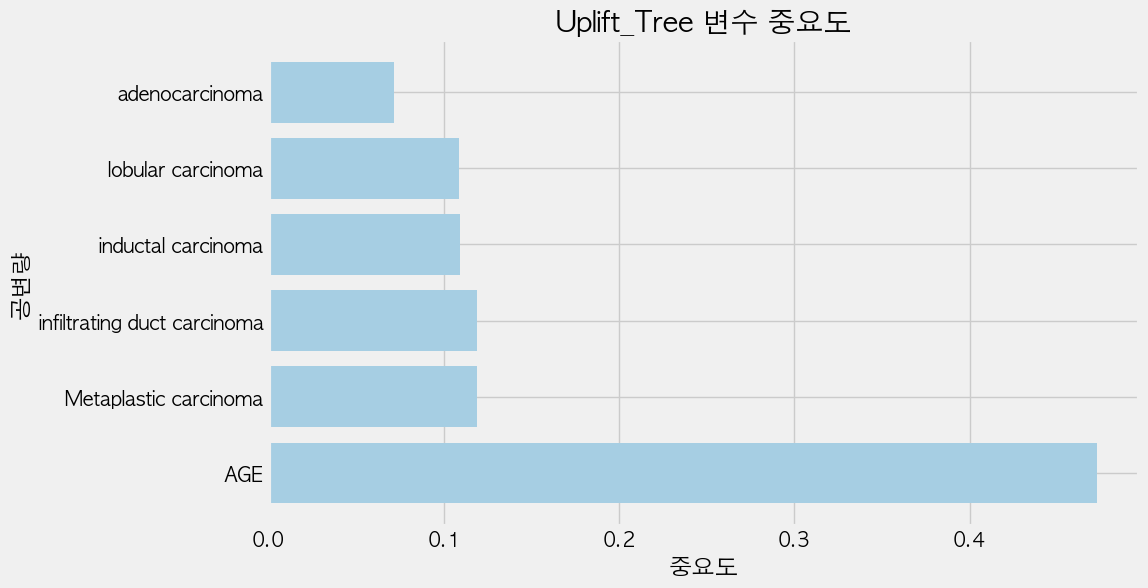

In [103]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

feature_importances = uplift_model.feature_importances_
feature_names = df_train[x_names].columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('Uplift_Tree 변수 중요도')
plt.show()

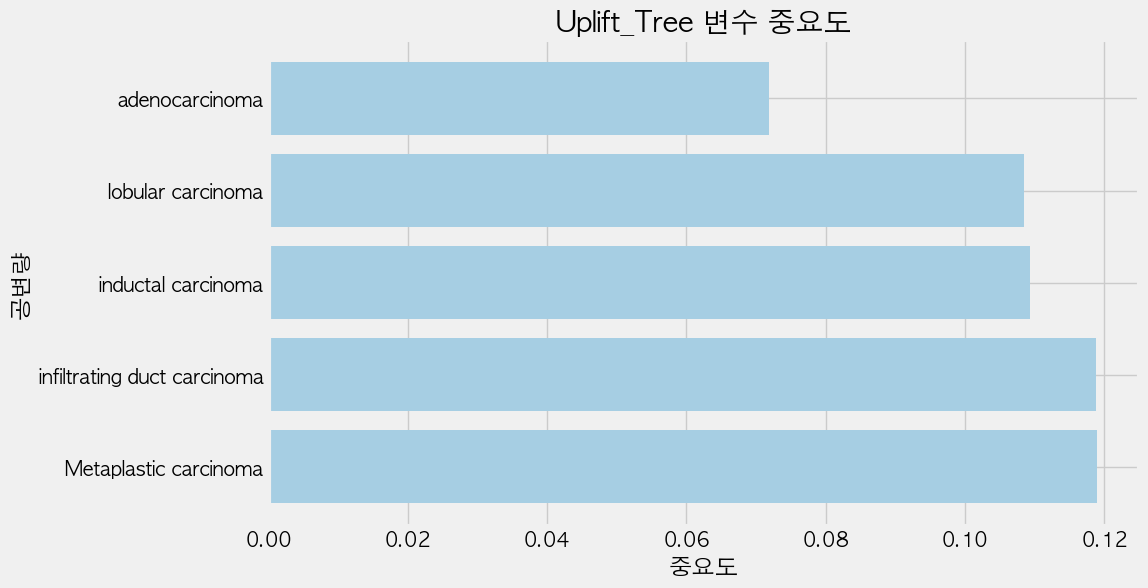

In [104]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

feature_importances = uplift_model.feature_importances_
feature_names = df_train[x_names].columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)
importance_df_sorted = importance_df_sorted[1:]
plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('Uplift_Tree 변수 중요도')
plt.show()

In [105]:
df_res = uplift_model.predict(df_test[x_names].values, full_output=True)
print(df_res.shape)
df_res.head()

(1783, 17)


,c,t1,t2,t3,t4,t5,t6,t7,recommended_treatment,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,max_delta
0,0.275472,0.303642,0.346104,0.363454,0.364779,0.369066,0.369815,0.393472,7,0.028170,0.070633,0.087982,0.089307,0.093594,0.094343,0.118000,0.118000
1,0.295725,0.297852,0.353604,0.370105,0.373943,0.349066,0.374290,0.411662,7,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937,0.115937
2,0.295725,0.297852,0.353604,0.370105,0.373943,0.349066,0.374290,0.411662,7,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937,0.115937
3,0.261350,0.324919,0.335554,0.381380,0.368335,0.341614,0.364908,0.420473,7,0.063569,0.074204,0.120030,0.106986,0.080264,0.103558,0.159123,0.159123
4,0.295725,0.297852,0.353604,0.370105,0.373943,0.349066,0.374290,0.411662,7,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937,0.115937


In [106]:
y_pred = uplift_model.predict(df_test[x_names].values)
y_pred.shape

(1783, 7)

In [107]:
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

,t1,t2,t3,t4,t5,t6,t7
0,0.028170,0.070633,0.087982,0.089307,0.093594,0.094343,0.118000
1,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937
2,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937
3,0.063569,0.074204,0.120030,0.106986,0.080264,0.103558,0.159123
4,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937


In [108]:
best_treatment = np.where((result < 0).all(axis=1),
                           'c',
                           result.idxmax(axis=1))

actual_is_best = np.where(df_test['combo_tx'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['combo_tx'] == 'c', 1, 0)
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

In [109]:
result

,t1,t2,t3,t4,t5,t6,t7
0,0.028170,0.070633,0.087982,0.089307,0.093594,0.094343,0.118000
1,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937
2,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937
3,0.063569,0.074204,0.120030,0.106986,0.080264,0.103558,0.159123
4,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937
...,...,...,...,...,...,...,...
1778,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937
1779,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937
1780,-0.023811,0.021069,0.049090,0.066380,0.041209,0.066248,0.076106
1781,0.002127,0.057880,0.074380,0.078218,0.053341,0.078565,0.115937


uplift_tree   -0.881262
dtype: float64


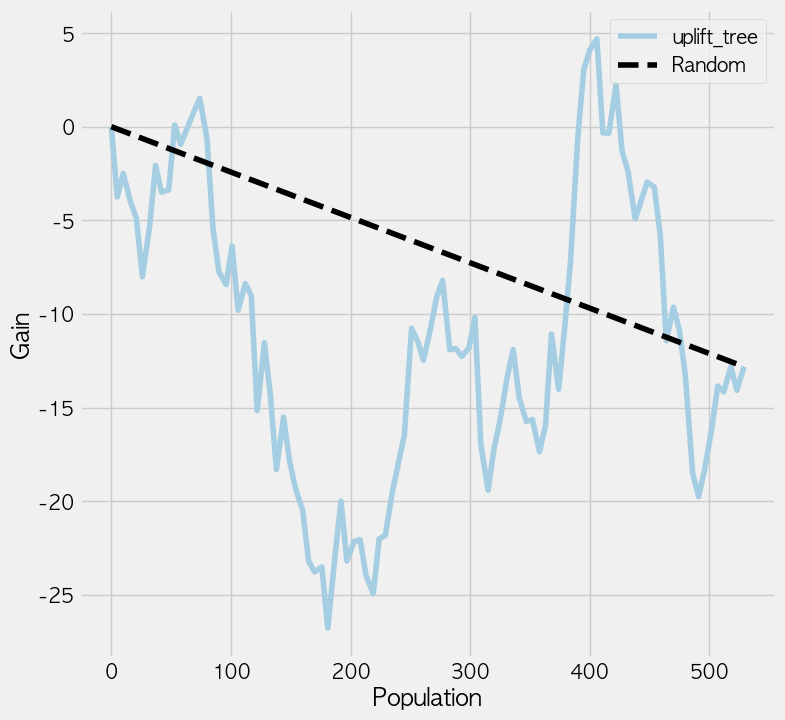

In [110]:
plt.rcParams['axes.unicode_minus'] = False

auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             Death = df_test.loc[synthetic, 'Survival period'].values.astype(int),
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))

score = auuc_score(auuc_metrics, outcome_col='Survival period', treatment_col='is_treated')
print(score)

plot_gain(auuc_metrics, outcome_col='Survival period', treatment_col='is_treated')

uplift_tree   -0.369986
dtype: float64


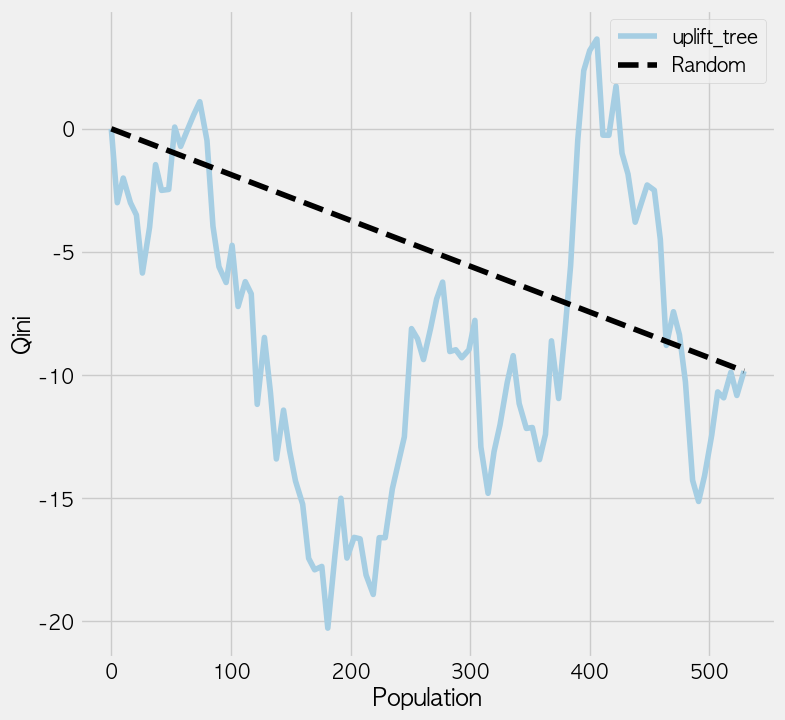

In [111]:
score = qini_score(auuc_metrics, outcome_col='Death', treatment_col='is_treated')
print(score)
plot_qini(auuc_metrics, outcome_col='Death', treatment_col='is_treated')